# 学習方法の例

In [13]:
import glob
import os
import pickle
import sys
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import util
from common.gradient import numerical_gradient
from common.layers import (Affine, Convolution, MaxPooling, ReLU,
                           SoftmaxWithLoss)
from common.models import TwoLayerNet, CustomConvNet_withBatchNorm
from common.optimizer import RMSProp, Adam
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from IPython.display import display

## データを読む1

In [2]:
train_data = np.load("../1_data/train_data.npy")
train_label = np.load("../1_data/train_label.npy")
print("train_data.shape=", train_data.shape)
print("train_label.shape=", train_label.shape)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


In [3]:
def onehot_to_str(label):
    """
    ワンホットベクトル形式のラベルをカタカナ文字に変換する
    """
    dic_katakana = {"a":0,"i":1,"u":2,"e":3,"o":4,"ka":5,"ki":6,"ku":7,"ke":8,"ko":9,"sa":10,"si":11,"su":12,"se":13,"so":14}
    label_int = np.argmax(label)
    for key, value in dic_katakana.items():
        if value==label_int:
            return key
X=[]
Y=[]
n = 6
data = train_data
for i in range(len(data)):
     # 画像読み込み
    data = np.load("../1_data/train_data.npy") 
    label = np.load("../1_data/train_label.npy")  
    data = data[i:i+1]
    label = label[i:i+1]
    label_katakana = onehot_to_str(label)

    # 軸をN,H,W,Cに入れ替え
    data = data.transpose(0,2,3,1)

    # ImageDataGeneratorのオブジェクト生成
    datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range = 0.1,
        shear_range = 0.2,
        rotation_range = 15
    )

    # 生成後枚数
    if label_katakana in ["a","i","u","e","o"]:
        num_image = 7*n
    else:
        num_image = 4*n

    # 生成
    g = datagen.flow(data)
    for i in range(num_image):
            batches = g.next()
            X.append(batches)
            Y.append(label)
X = np.array(X)
Y = np.array(Y)
X2 = np.squeeze(X, 1).copy()
Y2 = np.squeeze(Y, 1).copy()
print(X2.shape)

(90000, 28, 28, 1)


(90000, 1, 28, 28)


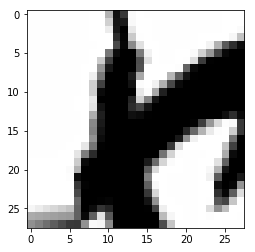

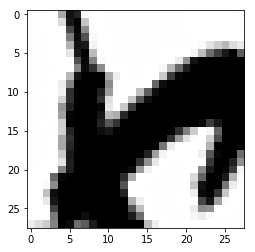

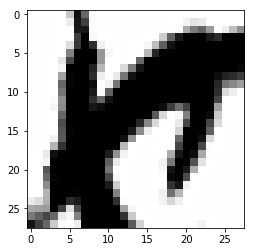

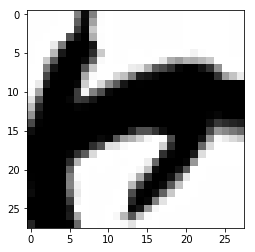

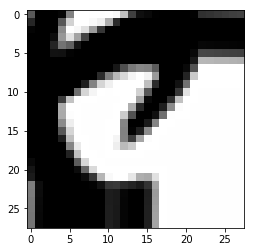

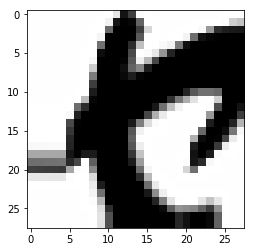

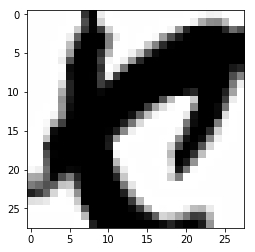

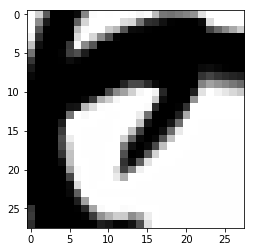

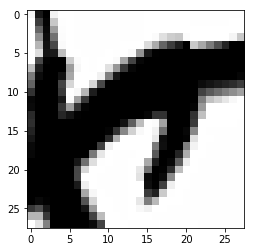

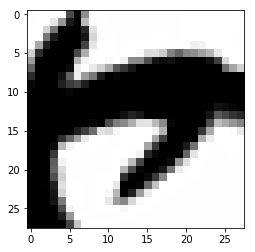

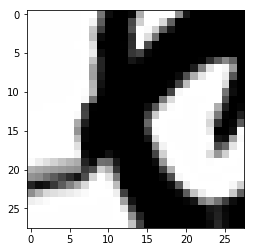

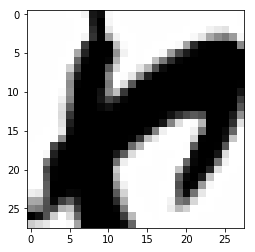

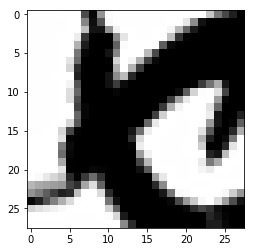

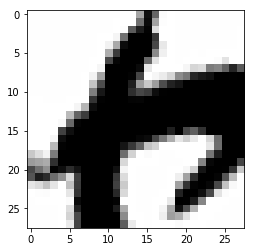

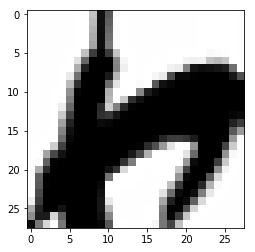

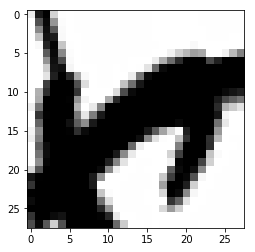

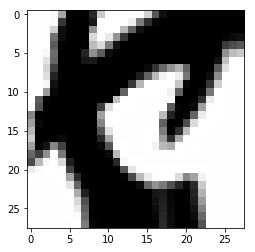

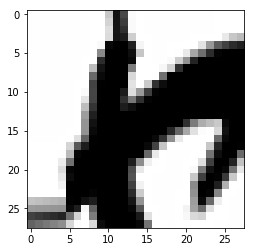

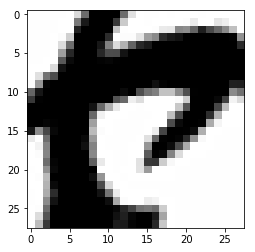

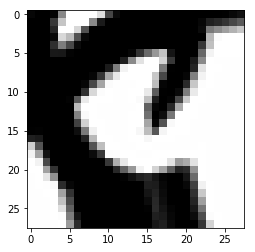

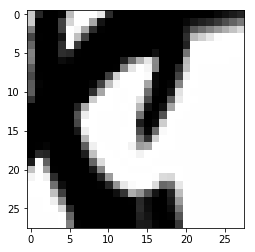

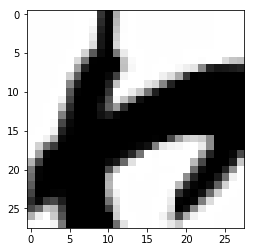

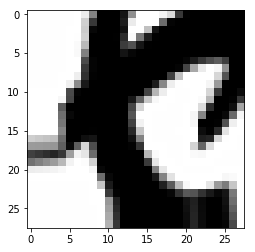

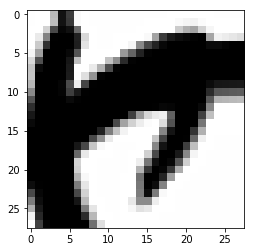

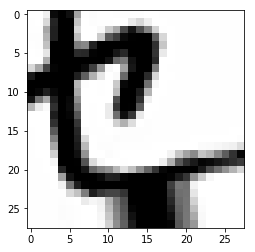

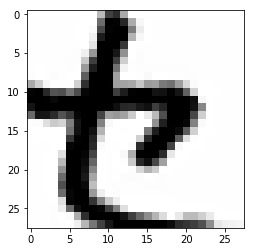

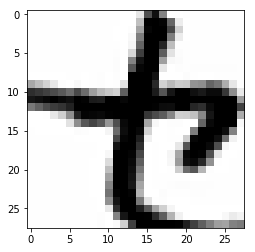

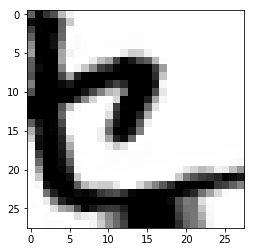

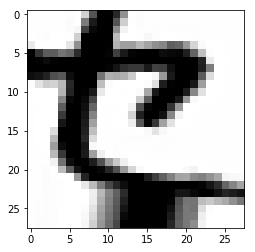

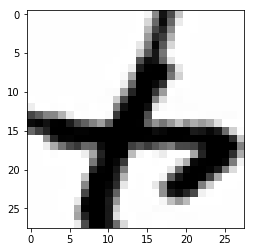

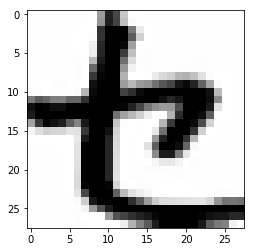

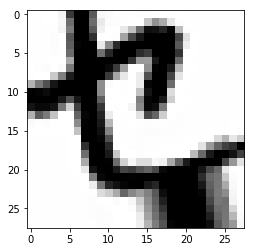

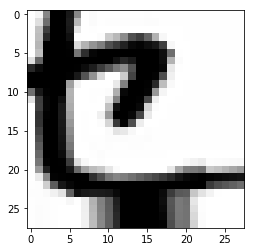

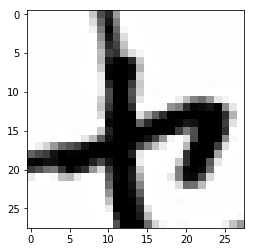

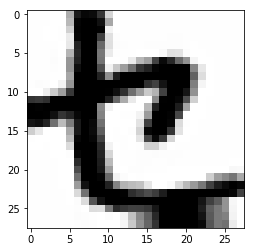

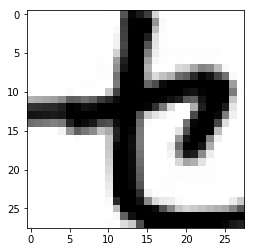

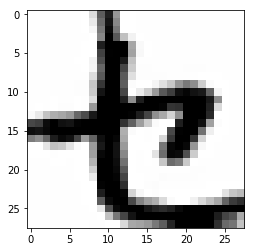

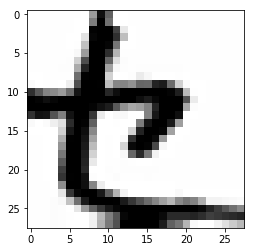

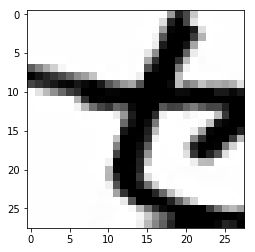

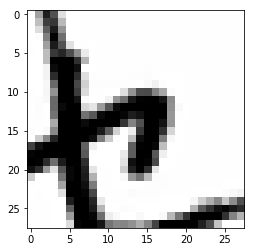

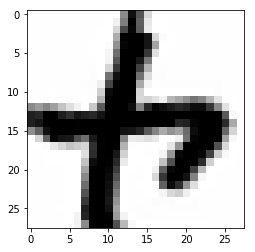

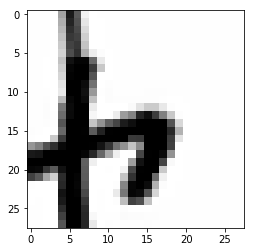

In [4]:
# 画像
X2 = X2.transpose(0,3,1,2)
print(X2.shape)
for i in range(num_image):
    img = X2[i,:,:,:,]
    plt.imshow(img[0,:,:], cmap='gray')
    plt.show()

In [5]:
# 正規化
X2 = (X2 - X2.min()) / X2.max()
X2 = X2.astype('float32')
print("train_data.shape=", X2.shape)

train_data.shape= (90000, 1, 28, 28)


## trainとtestに分割する

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.3, random_state=1234,shuffle=True)
print(X_train.shape, X_test.shape)

(63000, 1, 28, 28) (27000, 1, 28, 28)


## モデル作成

## 学習

In [8]:
epochs = 100
batch_size = 32
lr = 0.001
early_stopping = 5
count = 0
callback = 5
optimizer = Adam(lr)
# 繰り返し回数
xsize = X_train.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# 2層NNのオブジェクト生成
# model = TwoLayerNet(input_size=28*28, hidden_size=10, output_size=15)

# CNNのオブジェクト生成
with open("katakana_model_weight.pickle", "rb") as f:
        model_weight = pickle.load(f)
from common.layers import SimpleConvNet
# model = SimpleConvNet(input_dim=(1, 28, 28), 
#                      conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
#                      pool_param={'pool_size':2, 'pad':0, 'stride':2},
#                      hidden_size=100, output_size=15, weight_init_std=0.01, pretrained_weights=model_weight)

model = CustomConvNet_withBatchNorm(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':30, 'filter_size':3, 'pad':0, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=100, output_size=15, weight_init_std=0.01)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in tqdm(range(iter_num)):
        """
        ランダムなミニバッチを順番に取り出す
        """
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_ = X_train[mask]
        y_ = y_train[mask]

        # 勾配の計算
        grads = model.gradient(x_, y_)
        
        # パラメータの更新
        
    optimizer.update(model.params, grads)
#         for key in model.params.keys():
#             model.params[key] -= lr * grads[key]

    ## 学習経過の記録

    # 訓練データにおけるloss
    train_loss.append(model.loss(X_train,  y_train))

    # テストデータにおけるloss
    test_loss.append(model.loss(X_test, y_test))

    # 訓練データにて精度を確認
    train_accuracy.append(model.accuracy(X_train, y_train))

    # テストデータにて精度を算出
    test_accuracy.append(model.accuracy(X_test, y_test))
    
    # 最良な重み保存
    if epoch == 0:
        best_test_loss = test_loss[epoch]
    if best_test_loss >= test_loss[epoch]:
            best_model_params = model.params

    if epoch == 0 or (epoch + 1)  % callback == 0: 
        print("Epoch %d" % (epoch + 1), "train_loss", train_loss[epoch],"train_accuracy",train_accuracy[epoch], "test_loss", test_loss[epoch], "test accuracy", test_accuracy[epoch])
    
    #    早期終了(Early Stopping)
    if test_loss[epoch] >= test_loss[epoch-1]:
        count += 1
        if count >= early_stopping:
            print("Early Stopping !")
            break
    else:
        count=0
    

  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 1 train_loss 0.22620723030158593 train_accuracy 0.930936507936508 test_loss 0.3002765169110643 test accuracy 0.9098148148148149


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 5 train_loss 0.07979642089069335 train_accuracy 0.9728095238095238 test_loss 0.22525471407772427 test accuracy 0.9388888888888889


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 10 train_loss 0.039298967215020034 train_accuracy 0.9871269841269841 test_loss 0.2294317094241999 test accuracy 0.9481481481481482


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 15 train_loss 0.025102994432781103 train_accuracy 0.9926190476190476 test_loss 0.2608323913916602 test accuracy 0.9504814814814815


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 20 train_loss 0.011653768603076882 train_accuracy 0.9963015873015874 test_loss 0.25388364708997635 test accuracy 0.9565555555555556


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 25 train_loss 0.011218269584439083 train_accuracy 0.9966825396825397 test_loss 0.27659691669655423 test accuracy 0.9567037037037037


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 30 train_loss 0.008290811751363791 train_accuracy 0.9977142857142857 test_loss 0.29657641572298493 test accuracy 0.956962962962963


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 35 train_loss 0.006813423870102564 train_accuracy 0.9981111111111111 test_loss 0.31781045523985274 test accuracy 0.9572592592592593


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 40 train_loss 0.005773040597266811 train_accuracy 0.9981587301587301 test_loss 0.3269542156983747 test accuracy 0.9565185185185185


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 45 train_loss 0.004565603647626588 train_accuracy 0.9986825396825397 test_loss 0.333249213842134 test accuracy 0.9565925925925925


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 50 train_loss 0.003924803249003494 train_accuracy 0.9989206349206349 test_loss 0.3159754594182485 test accuracy 0.9591481481481482


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 55 train_loss 0.003493967284314402 train_accuracy 0.9989206349206349 test_loss 0.3299777041649539 test accuracy 0.9578888888888889


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 60 train_loss 0.006986806339190229 train_accuracy 0.9981269841269841 test_loss 0.3648283934475443 test accuracy 0.9545185185185185


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 65 train_loss 0.004578971811116148 train_accuracy 0.9988888888888889 test_loss 0.3603170851311541 test accuracy 0.9574444444444444


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 70 train_loss 0.0034232253297125947 train_accuracy 0.998968253968254 test_loss 0.37179623606503776 test accuracy 0.9577407407407408


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 75 train_loss 0.008999298587997695 train_accuracy 0.9977777777777778 test_loss 0.4062428137204486 test accuracy 0.9533333333333334


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 80 train_loss 0.001244060503040355 train_accuracy 0.9996984126984128 test_loss 0.3654689077101499 test accuracy 0.9598518518518518


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 85 train_loss 0.004016247980936622 train_accuracy 0.9990793650793651 test_loss 0.3983317295759358 test accuracy 0.9570740740740741


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 90 train_loss 0.007791717467299855 train_accuracy 0.997968253968254 test_loss 0.42857323908002926 test accuracy 0.9535555555555556


  0%|          | 0/1969 [00:00<?, ?it/s]

Epoch 95 train_loss 0.000807212384192574 train_accuracy 0.9997460317460317 test_loss 0.4029908131680487 test accuracy 0.9575555555555556


100%|██████████| 1969/1969 [05:41<00:00,  5.77it/s]


Epoch 100 train_loss 0.0024343230751212807 train_accuracy 0.9993492063492063 test_loss 0.4059901839460873 test accuracy 0.9580740740740741


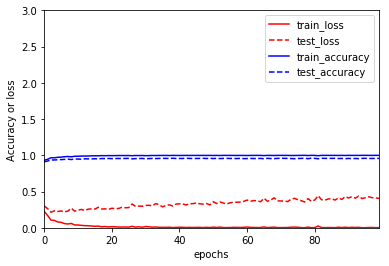

In [9]:
# lossとaccuracyのグラフ化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})

df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
plt.ylim([0,3])
plt.ylabel("Accuracy or loss")
plt.xlabel("epochs")
plt.show()

In [10]:
model.params = best_model_params
accuracy = model.accuracy(X_test, y_test)
loss  = model.loss(X_test, y_test)
print(accuracy, loss)

0.9580740740740741 0.4059901839460873


In [11]:
from datetime import datetime as dt
from pytz import timezone

tdatetime = dt.now(timezone('Asia/Tokyo'))
tstr = tdatetime.strftime('%Y%m%d%H%M')

## 学習済みモデルの出力

In [12]:
with open("katakana_model_weight_%s.pickle" %tstr , "wb") as f:
    pickle.dump(best_model_params, f)
    